In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser
import os

path_to_results = r'C:\Users\huda\Downloads\\'
#path_to_results = r'/home/dhu/Downloads/results/'

In [2]:
ga_path = r'C:\Users\huda\Downloads\ga_worker_results\results.json'
import json
with open(ga_path, 'r') as f:
    ga_data = json.loads(f.read())

In [3]:
ga_data

{'BehnkeGeiger_10_workers': {'best': 136.0, 'average': 139.27777777777777},
 'BehnkeGeiger_11_workers': {'best': 294.0, 'average': 313.3333333333333},
 'BehnkeGeiger_12_workers': {'best': 289.0, 'average': 305.77777777777777},
 'BehnkeGeiger_13_workers': {'best': 290.0, 'average': 306.72222222222223},
 'BehnkeGeiger_14_workers': {'best': 293.0, 'average': 315.3888888888889},
 'BehnkeGeiger_15_workers': {'best': 295.0, 'average': 310.5},
 'BehnkeGeiger_16_workers': {'best': 705.0, 'average': 740.9444444444445},
 'BehnkeGeiger_17_workers': {'best': 693.0, 'average': 724.6666666666666},
 'BehnkeGeiger_18_workers': {'best': 694.0, 'average': 725.3333333333334},
 'BehnkeGeiger_19_workers': {'best': 698.0, 'average': 728.0},
 'BehnkeGeiger_1_workers': {'best': 88.0, 'average': 90.22222222222223},
 'BehnkeGeiger_20_workers': {'best': 702.0, 'average': 716.3888888888889},
 'BehnkeGeiger_21_workers': {'best': 81.0, 'average': 81.83333333333333},
 'BehnkeGeiger_22_workers': {'best': 82.0, 'avera

In [4]:
from ast import literal_eval
files = [path_to_results + r'results_ortools.txt', path_to_results +r'results_cplex_cp.txt', path_to_results +r'results_gurobi.txt', path_to_results +r'results_hexaly_rewritten.txt', path_to_results +r'results_cplex_lp_rewritten.txt']
all_data = dict()
data_as_dict = dict()
for file in files:
    file_content = pd.read_csv(file, names=['name','optimization_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2', 'result_vector3', 'peak_cpu', 'peak_ram', 'resource_history', 'best_result_history'], sep=';')#, converters={'best_result_history': pd.eval})
    df = pd.DataFrame(file_content)
    name = file.split('\\')[-1][8:-4]
    if name == 'hexaly_rewritten':
        name = 'hexaly'#all_data['results_hexaly'] = df
    elif name == 'cplex_lp_rewritten':
         name = 'cplex_lp'#all_data['results_cplex_lp'] = df
    all_data[name] = df
    for index, row in df.iterrows():
        if name not in data_as_dict:
            data_as_dict[name] = dict()
        data_as_dict[name][row['name'][2:-4]] = row['fitness_value']
del df
del file_content

In [5]:
data_as_dict['ga_best'] = dict()
data_as_dict['ga_average'] = dict()
for key in ga_data.keys():
    entry = ga_data[key]
    data_as_dict['ga_best'][key] = entry['best']
    data_as_dict['ga_average'][key] = entry['average']

In [6]:
def calculate_value(fitness, best):
    return ((fitness - best) / best)

In [11]:
def ecdf_inf(vectors, column, max : bool = False, n_instances : int = 402, labels : list[str] = [], instances : list[str] = []):
    
    plot_vectors = []
    for vector in vectors:
        plot_vectors.append([[0.0],[0.0]])
        i = 1
        while i < len(vector):
            if vector[i] == float('inf'):
                break
            if vector[i] == -float('inf'):
                break
            while i < len(vector) and vector[i] == vector[i-1]:
                i += 1
            plot_vectors[-1][0].append(vector[i-1])
            plot_vectors[-1][1].append((i-1)/n_instances)
            i += 1
    for i in range(len(vectors)):
        plt.plot(plot_vectors[i][0], plot_vectors[i][1], label=[labels[i]])
    if column == 'fitness_value':
        plt.xlim(-0.1, 1.0)
        
    plt.legend()
    plt.title(column)
    plt.show()

In [12]:
plot_data = dict()
for key in data_as_dict['ga_best'].keys():
    best = float('inf')
    plot_data[key] = dict()
    for solver in data_as_dict.keys():
        if key in data_as_dict[solver] and data_as_dict[solver][key] < best:
            best = data_as_dict[solver][key]
    for solver in data_as_dict.keys():
        if key in data_as_dict[solver]:
            plot_data[key][solver] = calculate_value(data_as_dict[solver][key], best)
        else:
            plot_data[key][solver] = float('inf')

In [13]:
vectors = []
labels = []
for solver in data_as_dict.keys():
    labels.append(solver)
    vector = []
    for instance in data_as_dict['ga_best'].keys():
        vector.append(plot_data[instance][solver])
    vector.sort()
    vectors.append(vector)

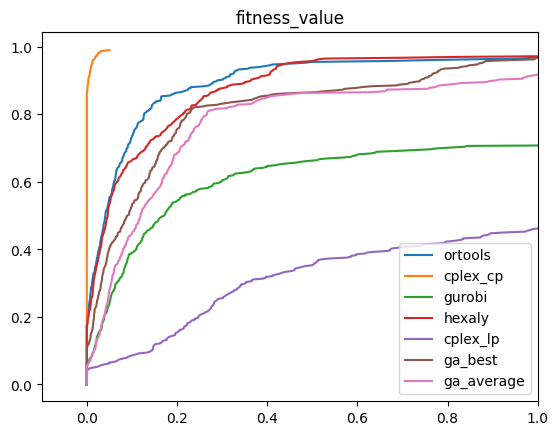

In [14]:
ecdf_inf(vectors, 'fitness_value', labels=labels)